# Generate composite galaxy

Finall, in this example we're going to demonstrate how to make a composite galaxy, including with imaging. For more information on defining parametric morphology see the Imaging examples.

In [1]:
from unyt import yr, Myr, kpc, mas, Msun, Angstrom, deg
import matplotlib.pyplot as plt
import numpy as np
from synthesizer.grid import Grid
from synthesizer.parametric.morphology import Sersic2D, PointSource
from synthesizer.parametric import SFH, ZDist, Stars
from synthesizer.parametric.galaxy import Galaxy
from synthesizer.blackholes import UnifiedAGN
from synthesizer.parametric import BlackHoles
from synthesizer.sed import plot_spectra
from synthesizer.filters import UVJ

Let's begin by defining the geometry of the images:

In [2]:
# Define geometry of the images
resolution = 0.1 * kpc  # resolution in kpc
npix = 50
fov = resolution * npix

Define the `grid_dir`:

In [3]:
grid_dir = '../../../tests/test_grid'

## The Stars

Let's first build the stellar component of our galaxy, including setting the morphology so we can make an image later.

First define the grid. We need this to create our star formation and metal enrichment history.

In [4]:
grid_name = 'test_grid'
grid = Grid(grid_name, grid_dir=grid_dir)

Let's define our star formation and metal enrichment history:

In [5]:
sfh_p = {'duration': 10 * Myr}
Z_p = {'log10metallicity': -2.0}  # can also use linear metallicity e.g. {'Z': 0.01}
stellar_mass = 10 ** 9.5
sfh = SFH.Constant(**sfh_p)  # constant star formation
metal_dist = ZDist.DeltaConstant(**Z_p)  # constant metallicity

Next, let's define the morphology:

In [6]:
morph = Sersic2D(r_eff=1.*kpc, sersic_index=1., ellipticity=0.5, theta=35.)

Now let's initialise our stars object:

In [7]:
# Get the 2D star formation and metal enrichment history for the given SPS grid. This is (age, Z).
stars = Stars(
    grid.log10age, grid.metallicity, sf_hist=sfh, metal_dist=metal_dist, initial_mass=stellar_mass, morphology=morph
)

Now generate the stellar spectra:

In [8]:
stars.get_spectra_pacman(grid, tau_v = 0.5, alpha=-1)

## The blackholes

Let's define the properties of our blackholes. We don't need to define the morphology since blackholes automatically assume a `PointSource` geometry.

In [9]:
black_hole = BlackHoles(mass=1E8*Msun, inclination=15*deg, accretion_rate=1.*Msun/yr, metallicity=0.01)

Next, let's define the emission model and generate the spectra.

In [10]:
emission_model = UnifiedAGN(disc_model='test_grid_agn', photoionisation_model='', grid_dir=grid_dir)

# get the spectra assuming this emission model
black_hole.get_spectra(emission_model)

/opt/hostedtoolcache/Python/3.10.13/x64/lib/python3.10/site-packages/unyt/array.py:1813: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)


{'disc_incident': <synthesizer.sed.Sed at 0x7f8090f41f00>,
 'disc_transmitted': <synthesizer.sed.Sed at 0x7f80dc600b80>,
 'disc_escaped': <synthesizer.sed.Sed at 0x7f8090eeae30>,
 'disc': <synthesizer.sed.Sed at 0x7f8090eeac20>,
 'blr': <synthesizer.sed.Sed at 0x7f8090eeb4c0>,
 'nlr': <synthesizer.sed.Sed at 0x7f8090eeae90>,
 'torus': <synthesizer.sed.Sed at 0x7f8090eeb0d0>,
 'total': <synthesizer.sed.Sed at 0x7f80dc603af0>}

## The Galaxy

Initialise the Galaxy object, make an image and plot it. In this case, we can make a colour image using our UVJ filters:

In [11]:
# Initialise Galaxy object
galaxy = Galaxy(stars=stars, black_holes=black_hole)
print(galaxy)

-------------------------------------------------------------------------------
                            SUMMARY OF PARAMETRIC GALAXY                           
                           ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⣀⡀⠒⠒⠦⣄⡀⠀⠀⠀⠀⠀⠀⠀                          
                           ⠀⠀⠀⠀⠀⢀⣤⣶⡾⠿⠿⠿⠿⣿⣿⣶⣦⣄⠙⠷⣤⡀⠀⠀⠀⠀                          
                           ⠀⠀⠀⣠⡾⠛⠉⠀⠀⠀⠀⠀⠀⠀⠈⠙⠻⣿⣷⣄⠘⢿⡄⠀⠀⠀                          
                           ⠀⢀⡾⠋⠀⠀⠀⠀⠀⠀⠀⠀⠐⠂⠠⢄⡀⠈⢿⣿⣧⠈⢿⡄⠀⠀                          
                           ⢀⠏⠀⠀⠀⢀⠄⣀⣴⣾⠿⠛⠛⠛⠷⣦⡙⢦⠀⢻⣿⡆⠘⡇⠀⠀                          
                           ⠀⠀⠀+-+-+-+-+-+-+-+-+-+-+-+⡇⠀⠀                           
                           ⠀⠀⠀|S|Y|N|T|H|E|S|I|Z|E|R|⠃⠀⠀                           
                           ⠀⠀⢰+-+-+-+-+-+-+-+-+-+-+-+⠀⠀⠀                           
                           ⠀⠀⢸⡇⠸⣿⣷⠀⢳⡈⢿⣦⣀⣀⣀⣠⣴⣾⠟⠁⠀⠀⠀⠀⢀⡎                          
                           ⠀⠀⠘⣷⠀⢻⣿⣧⠀⠙⠢⠌⢉⣛⠛⠋⠉⠀⠀⠀⠀⠀⠀⣠⠎⠀                          
                        

In [12]:
galaxy.spectra = {}
galaxy.spectra['black_holes'] = galaxy.black_holes.spectra['total']
galaxy.spectra['stars'] = galaxy.stars.spectra['attenuated']
galaxy.spectra['total'] = galaxy.spectra['stars'] + galaxy.spectra['black_holes']

### Spectra

We can use the `plot_spectra` function to make a quick spectrum of the galaxy. 

(<Figure size 350x500 with 1 Axes>,
 <Axes: xlabel='$\\lambda/[\\mathrm{Å}]$', ylabel='$L_{\\nu}/[\\mathrm{erg\\ / \\ (Hz \\ s)}]$'>)

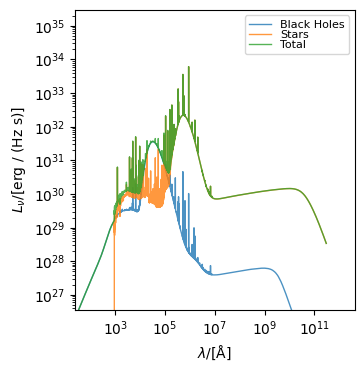

In [13]:
plot_spectra(galaxy.spectra)

### Images

Let's define some filters.

In [14]:
filters = UVJ(new_lam=grid.lam)

Let's look at the total spectra.

Now let's make some images.

-------------------------------------------------------------------------------
                            SUMMARY OF PARAMETRIC GALAXY                           
                           ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⣀⣀⡀⠒⠒⠦⣄⡀⠀⠀⠀⠀⠀⠀⠀                          
                           ⠀⠀⠀⠀⠀⢀⣤⣶⡾⠿⠿⠿⠿⣿⣿⣶⣦⣄⠙⠷⣤⡀⠀⠀⠀⠀                          
                           ⠀⠀⠀⣠⡾⠛⠉⠀⠀⠀⠀⠀⠀⠀⠈⠙⠻⣿⣷⣄⠘⢿⡄⠀⠀⠀                          
                           ⠀⢀⡾⠋⠀⠀⠀⠀⠀⠀⠀⠀⠐⠂⠠⢄⡀⠈⢿⣿⣧⠈⢿⡄⠀⠀                          
                           ⢀⠏⠀⠀⠀⢀⠄⣀⣴⣾⠿⠛⠛⠛⠷⣦⡙⢦⠀⢻⣿⡆⠘⡇⠀⠀                          
                           ⠀⠀⠀+-+-+-+-+-+-+-+-+-+-+-+⡇⠀⠀                           
                           ⠀⠀⠀|S|Y|N|T|H|E|S|I|Z|E|R|⠃⠀⠀                           
                           ⠀⠀⢰+-+-+-+-+-+-+-+-+-+-+-+⠀⠀⠀                           
                           ⠀⠀⢸⡇⠸⣿⣷⠀⢳⡈⢿⣦⣀⣀⣀⣠⣴⣾⠟⠁⠀⠀⠀⠀⢀⡎                          
                           ⠀⠀⠘⣷⠀⢻⣿⣧⠀⠙⠢⠌⢉⣛⠛⠋⠉⠀⠀⠀⠀⠀⠀⣠⠎⠀                          
                        

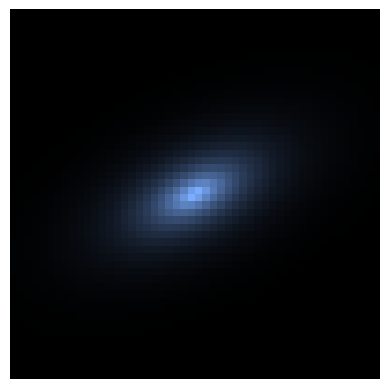

In [15]:

# Make images
img = galaxy.make_images(
    resolution=resolution,
    filters=filters,
    sed=galaxy.stars.spectra["incident"],
    # npix=npix,
    fov=fov,
)

print(galaxy)

# Make and plot an rgb image
img.make_rgb_image(rgb_filters={"R" : 'J',
                                "G" : 'V',
                                "B" : 'U'})
fig, ax, _ = img.plot_rgb_image(show=True)